# Aequam Capital : Reinforcement Learning appliqué à la gestion de portefeuilles

### Import des librairies utiles

In [2]:
import gym
from gym import spaces

import warnings
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import empyrical

from stable_baselines.common.policies import MlpPolicy, MlpLstmPolicy
from stable_baselines.deepq.policies import MlpPolicy as DQN_MlpPolicy
from stable_baselines import A2C, PPO2, DQN, ACKTR, TRPO
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv

from sklearn.model_selection import ParameterGrid

from aequam_env import AequamEnv
from fpdf import FPDF
from backtest_utils import *

import skopt
from skopt import plots

### Accès à une adresse mail pour l'envoi de reporting mail automatiques

In [2]:
gmail_user = 'dorian.lagadec@aequamcapital.com'  
gmail_password = 'Aequaminternship0#'

### Création des jeux de données de deux types :
- données explicatives 'df_obs' : importées et créées dans 'Create and visualize datasets'.ipynb (leur description est dans le notebook également) ;
- données des actifs à échanger 'df_prices' : un DataFrame qui contient $n$ colonnes signifie que l'agent peut échanger $n$ actifs et les colonnes contiennent les prix de chacun de ces actifs. Ici, 
    - df_prices_all contient les 6 facteurs académiques retenus (auxquels on ajoute une colonne constante pour du cash) ;
    - df_prices_on_off contient une colonne des 6 facteurs équipondérés (avec le cash encore) ;
    - df_prices_modes contient 3 'actifs' : un portefeuille défensif - équipondéré des 3 facteurs défensifs -, un portefeuille offensif - même logique -, un portefeuille équipondéré (avec le cash toujours);
    - ...libre à l'utilisateur de créer d'autres DataFrames sur le même modèle, pour donner plus de liberté à l'agent de trading.

In [11]:
df_obs_1 = pd.read_csv('data/dataset1.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_2 = pd.read_csv('data/dataset2.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_3 = pd.read_csv('data/dataset3.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_4 = pd.read_csv('data/dataset4.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_5 = pd.read_csv('data/dataset5.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_6 = pd.read_csv('data/dataset6.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])
df_obs_7 = pd.read_csv('data/dataset7.csv', index_col = 0, parse_dates=True, usecols = lambda x: x not in ['Equi_weighted'])



df_prices_base = pd.read_csv('data/test.csv', index_col = 0, parse_dates=True, usecols = [i for i in range(7)])

df_prices_all = df_prices_base.copy()
df_prices_on_off = pd.DataFrame(df_prices_base.mean(axis=1), columns = ['Equally_weighted'])
df_prices_modes = pd.concat([df_prices_base[['Value','Momentum','Carry']].mean(axis=1), \
                            df_prices_on_off,\
                            df_prices_base[['Quality','Profitability','Size']].mean(axis=1) ], axis=1)
df_prices_modes.columns = ['Offensive','Equally_weighted','Defensive']

def df_obs_and_prices(num, asset):
    df_obs = globals()[f'df_obs_{num}']
    df_prices = globals()[f'df_prices_{asset}']
    return(df_obs, df_prices)

### Définitions des paramètres d'environnement initiaux (lire la docstring). Sont importants surtout ceux qui ne seront pas variables dans l'optimisation des backtests

In [12]:
n_filter = 16
# n_episodes = 100
lookback_window = 22
reward_type = 'delayed'
total_timesteps = 92648
transaction_smoothing = 4.82
algo = 'dqn'
num_df = 3
asset = 'modes'
random_proportion = 0.05
prefix = 'Test_I'
print_report=True
transaction_cost = 0.001
reward_window = 16
risk_aversion = 8.18

#A changer : 
REPORT_PATH = 'C:/Users/Avisia/Documents/Dorian/Gym_RL/Aequam_v0/reports/'

## I - Test d'un modèle de RL avec un jeu de paramètres fixés
Cette partie de code permet, avec un jeu de paramètres fixé ci-dessus, de lancer un apprentissage via un algorithme de RL, de rejouer le dernier épisode, de sauvegarder ce dernier en pdf et d'envoyer un mail de confirmation.

In [13]:
#Set the observation variables and the assets to trade
df_obs, df_prices = df_obs_and_prices(num_df, asset)
#Truncate the second dataframe to have exactly the same format as the first one. Otherwise the algo won't work
df_prices = propagate_index(from_df=df_obs, to_df=df_prices)
#Define a Dummy Vectorized Environment (requirement from stable_baselines models) with the model of AequamEnv
env = DummyVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
                                     lookback_window = lookback_window, reward_type = reward_type,\
                                     transaction_smoothing = transaction_smoothing, \
                                     reward_window = reward_window, risk_aversion = risk_aversion, 
                                     report_path = REPORT_PATH)])
#Set the algorithm's type
if algo == 'dqn':   
    model = DQN(DQN_MlpPolicy, env, param_noise=True, verbose=0, tensorboard_log='tmp/')
elif algo == 'ppo2' :   
    model = PPO2(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
    total_timesteps *= 10
elif algo == 'a2c':
    model = A2C(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
elif algo == 'acktr':
    model = ACKTR(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
elif algo == 'trpo':
    model = TRPO(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
else:
    print(1/0)

#Launch the learning process
model.learn(total_timesteps=total_timesteps)
#Play the last episode
env.envs[0].play_last_episode(model)
#Save the last episode as pdf report
if print_report:
    env.envs[0].print_pdf_report(filename(prefix, n_filter, lookback_window, reward_type, total_timesteps,\
                                         np.round(transaction_smoothing,2)
                                          , algo, num_df, asset, reward_window, np.round(risk_aversion,2)))
#Send a confirmation email
send_report(gmail_user, gmail_password)

W0925 11:51:52.141289 12052 deprecation_wrapper.py:119] From C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\common\tf_util.py:98: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0925 11:51:52.148275 12052 deprecation_wrapper.py:119] From C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\common\tf_util.py:107: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0925 11:51:52.174203 12052 deprecation_wrapper.py:119] From C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\deepq\dqn.py:123: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0925 11:51:52.175202 12052 deprecation_wrapper.py:119] From C:\Users\Avisia\Anaconda3\envs\env_dorian\lib\site-packages\stable_baselines\deepq\build_graph.py:358: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0925

Email sent!


<Figure size 1080x504 with 0 Axes>

Une fois l'optimisation effectuée et si le backtest est satisfaisant, on peut décider de garder le modèle entraîné pour l'utiliser à des fins de prédiction, donc d'allocation. Pour cela, on le sauvegarde en format pickle avec le code ci-dessous. Cela sera utile lorsque l'optimisation sera terminée.

In [ ]:
#Si on veut enregistrer le modèle
# model.save('good_model.pkl')
#Et pour le charger et l'utiliser
# model.load('good_model.pkl')

## II - Test de jeux de paramètres "à l'aveugle"
Le code ci-dessous met le code précédent dans une fonction et utilise la fonction numpy.vectorize qui, supposément, accélère l'éxécution de tâches indépendante. Cette partie peut éventuellement être ignorée au profit de la partie III, mais reste utile si on veut revenir à un grid-testing aléatoire.

In [6]:
def wrapper(n_filter = n_filter, lookback_window = lookback_window, reward_type = reward_type, \
            total_timesteps = total_timesteps, transaction_smoothing = transaction_smoothing, \
            algo = algo, num_df = num_df, asset = asset, reward_window = reward_window, risk_aversion = risk_aversion, \
            random_proportion = random_proportion, prefix = prefix, print_report=print_report):
    #Essai aléatoire avec une certaine proportion, pour ne pas parcourir tous les jeux de paramètres
    if random.random() < random_proportion :
        try:
            df_obs, df_prices = df_obs_and_prices(num_df, asset)
            df_prices = propagate_index(from_df=df_obs, to_df=df_prices)
    #         import pdb;pdb.set_trace()
            env = DummyVecEnv([lambda: AequamEnv(df_obs.iloc[::n_filter], df_prices.iloc[::n_filter],\
                                                 lookback_window = lookback_window, reward_type = reward_type,\
                                                 transaction_smoothing = transaction_smoothing, \
                                                 reward_window = reward_window, risk_aversion = risk_aversion,
                                                 report_path = REPORT_PATH)])

            if algo == 'dqn':   
                model = DQN(DQN_MlpPolicy, env, param_noise=True, verbose=0, tensorboard_log='tmp/')
            elif algo == 'ppo2' :   
                model = PPO2(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
                total_timesteps *= 10
            elif algo == 'a2c':
                model = A2C(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
            elif algo == 'acktr':
                model = ACKTR(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
            elif algo == 'trpo':
                model = TRPO(MlpPolicy, env, verbose=0, tensorboard_log='tmp/')
            else:
                print(1/0)

            model.learn(total_timesteps=total_timesteps)

            env.envs[0].play_last_episode(model)

            if print_report:
                env.envs[0].print_pdf_report(filename(prefix, n_filter, lookback_window, reward_type, total_timesteps,\
                                                     np.round(transaction_smoothing,2)
                                                      , algo, num_df, asset, reward_window, np.round(risk_aversion,2)))
            send_report(gmail_user, gmail_password)
        except:
            return(1)
    
    #Le but est d'avoir un rapport entre le portefeuille et le benchmark (équipondéré)
    # qui soit stable, croissant et pondéré. On essaie donc d'avoir un Sharpe ratio de 
    # ce rapport entre deux portefeuilles qui soit le plus élevé possible.
    numbers = env.envs[0].df_render.iloc[lookback_window-2:-2,-1]
    diff_sharpe = empyrical.sharpe_ratio(np.diff(numbers) / numbers[1:])

    return(diff_sharpe)

vectorized_wrapper = np.vectorize(wrapper)

Une fois la fonction vectorisée définie, on peut définir la grille sur laquelle tester les paramètres.

In [6]:
grid = ParameterGrid({"n_filter": [1, 3, 7, 10],
                      "lookback_window": [10, 15, 20],
                      "reward_type": ['vol', 'daily'],
                      "total_timesteps": [5000, 10000, 20000, 50000],
                      "transaction_smoothing": [5, 10, 15],
                      "algo": ['dqn','ppo2','trpo'],
                      "num_df": [5, 6, 7],
                      "asset": ['all','modes'],
                      "reward_window": [5, 10, 20],
                      "risk_aversion": [3, 5, 7, 10]})
# grid_df = pd.DataFrame(grid).sample(frac=0.0005)
grid_df = pd.DataFrame(grid)

#Remove duplicates from subsets that don't take into account other parameters
grid_df = pd.concat([grid_df.loc[grid_df['reward_type'] == 'daily'].drop_duplicates(\
                subset=['n_filter','lookback_window','reward_type','total_timesteps','transaction_smoothing',\
                               'algo','num_df','asset']), grid_df.loc[grid_df['reward_type'] == 'vol']],axis=0)
grid_df = grid_df.sample(frac = random_proportion)

# random_proportion = 1


Enfin, pour lancer le test "à l'aveugle", on décommente les lignes ci-dessous (commentées pour ne pas risquer un temps d'éxécution trop long en cas de "Run all cells".

In [9]:
# warnings.filterwarnings('ignore')


# vectorized_wrapper(n_filter = grid_df['n_filter'].values, lookback_window = grid_df['lookback_window'].values,\
#                    reward_type = grid_df['reward_type'].values, \
#             total_timesteps = grid_df['total_timesteps'].values, transaction_smoothing = grid_df['transaction_smoothing'].values, \
#             algo = grid_df['algo'].values, num_df = grid_df['num_df'].values, asset = grid_df['asset'].values, \
#             reward_window = grid_df['reward_window'].values, risk_aversion = grid_df['risk_aversion'].values,\
#             random_proportion = random_proportion, prefix = prefix, print_report=print_report)

## III - Utilisation de scikit-optimize (skopt) pour passer d'un test à l'aveugle à une recherche efficace d'un optimum
Il existe des méthodes d'optimisation non convexe plus efficaces que le simple grid-testing. Scikit-optimize en propose certaines et c'est celles là qui sont mises en oeuvre dans le code ci-dessous.

### Définition de l'espace des paramètres
On aimerait garder des paramètres comme 'algo' ou 'asset' en tant que string (pour mieux les visualiser ensuite), et de faite la classe skopt.space.Categorical existe, mais elle n'est pas prise en charge dans les méthodes de visualisation ensuite. A l'heure actuelle, on est donc contraint de transformer des variables catégorielles en des variables entières...

In [15]:
SPACE_MODIF = [skopt.space.Integer(1, 20, name='n_filter',transform='normalize'),
         skopt.space.Integer(5, 25, name='lookback_window',transform='normalize'),
         skopt.space.Integer(0, 1 , name='reward_type'),
         skopt.space.Integer(1000, 100000, name='total_timesteps', transform='normalize'),
         skopt.space.Real(1, 30, name='transaction_smoothing', prior = 'log-uniform'),
         skopt.space.Integer(0, 2, name='algo'),
         skopt.space.Integer(1, 7, name='num_df'),
         skopt.space.Integer(0, 1, name='asset'),
         skopt.space.Integer(1, 20, name='reward_window'),
         skopt.space.Real(1, 20, name='risk_aversion', prior='uniform')
         ]

In [16]:
reward_type_list = ['vol','delayed']
algo_list = ['dqn','ppo2','trpo']
asset_list = ['all','modes']

#Point de départ pour l'optimisation (jeu de paramètres qui marchait bien dans les backtests). On peut le mettre en
#commentaire et l'enlever de la function skopt.forest_minimize si on ne veut pas partir d'un point de départ donné.
#Sinon, c'est utile pour reprendre l'optimisation morceaux par morceaux.
x0_modif = {'n_filter': 10, 'lookback_window':20, 'reward_type': 0, 'total_timesteps':10000, \
           'transaction_smoothing': 20, 'algo': 0, 'num_df': 7, 'asset': 0, 'reward_window': 5,\
           'risk_aversion': 3}

#Légère modification de la fonction wrapper ci-dessus pour prendre en charge le changement de paramètre de str à int
def wrapper_modif(n_filter = n_filter, lookback_window = lookback_window, reward_type = 0, \
            total_timesteps = total_timesteps, transaction_smoothing = transaction_smoothing, \
            algo = 0, num_df = num_df, asset = 0, reward_window = reward_window, risk_aversion = risk_aversion, \
            random_proportion = random_proportion, prefix = prefix, print_report=print_report):
    
    reward_type_i = reward_type_list[reward_type]
    algo_i = algo_list[algo]
    asset_i = asset_list[asset]
    
    
    return(wrapper(n_filter = n_filter, lookback_window = lookback_window, reward_type = reward_type_i, \
            total_timesteps = total_timesteps, transaction_smoothing = transaction_smoothing, \
            algo = algo_i, num_df = num_df, asset = asset_i, reward_window = reward_window, risk_aversion = risk_aversion, \
            random_proportion = random_proportion, prefix = 'modif_test', print_report=print_report))



In [11]:
@skopt.utils.use_named_args(SPACE_MODIF)
def objective_modif(**params):
    all_params = {**params}#, **STATIC_PARAMS}
    return -1.0 * wrapper_modif(**all_params)

Pour lancer l'optimisation, on décommente les lignes ci-dessous

In [ ]:
warnings.filterwarnings('ignore')
results_modif = skopt.forest_minimize(objective_modif, SPACE_MODIF, n_calls=250, acq_func='LCB', x0=list(x0_modif.values()),\
                                      random_state=1, verbose=True, n_points=50, n_jobs=-1)#, **HPO_PARAMS)
skopt.dump(results_modif, 'results_modif.pkl')

Sinon, on charge des résultats d'une optimisation déjà faite précédemment.

$ATTENTION$ : pour des questions de stockage, le fichier à charger est compressé. Bien penser à le décompresser avant de lancer la ligne de code suivante.

In [13]:
results_we = skopt.load('results_we.pkl')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E596F41518>,
      dtype=object)

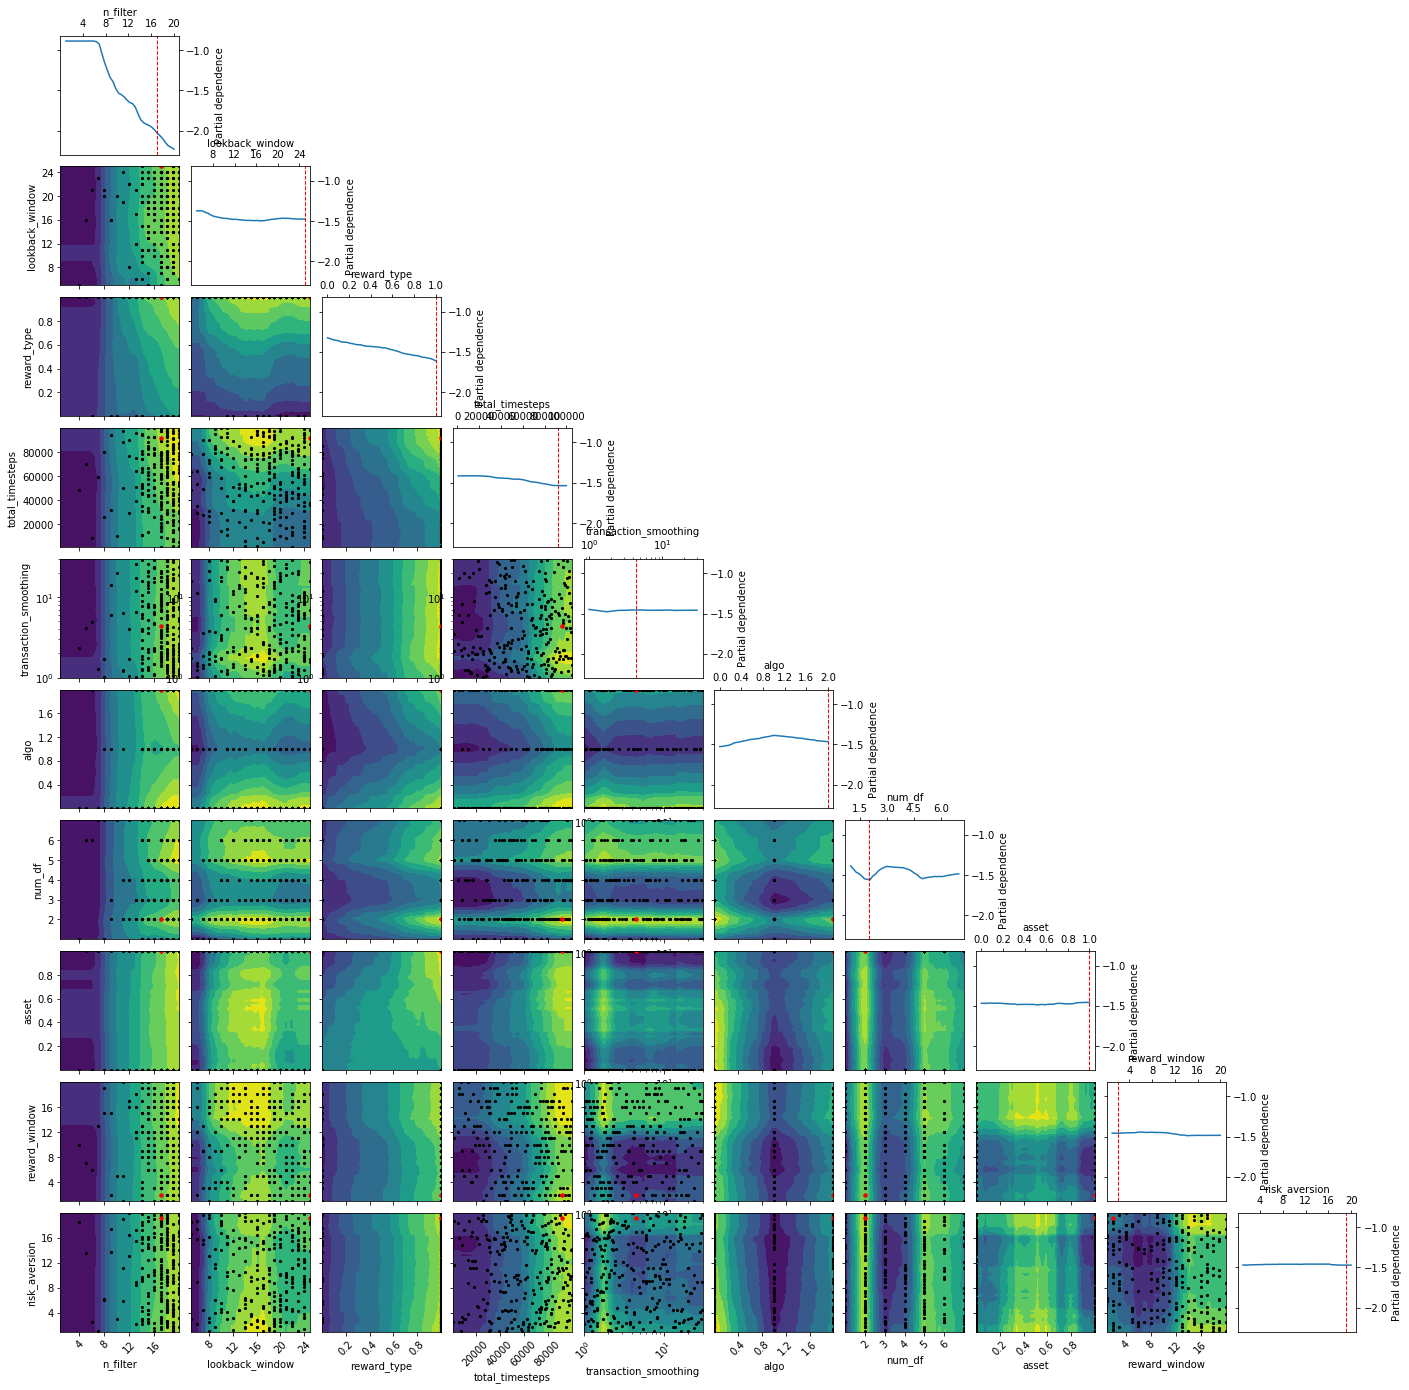

In [15]:
plots.plot_objective(results_we)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5874235C0>,
      dtype=object)

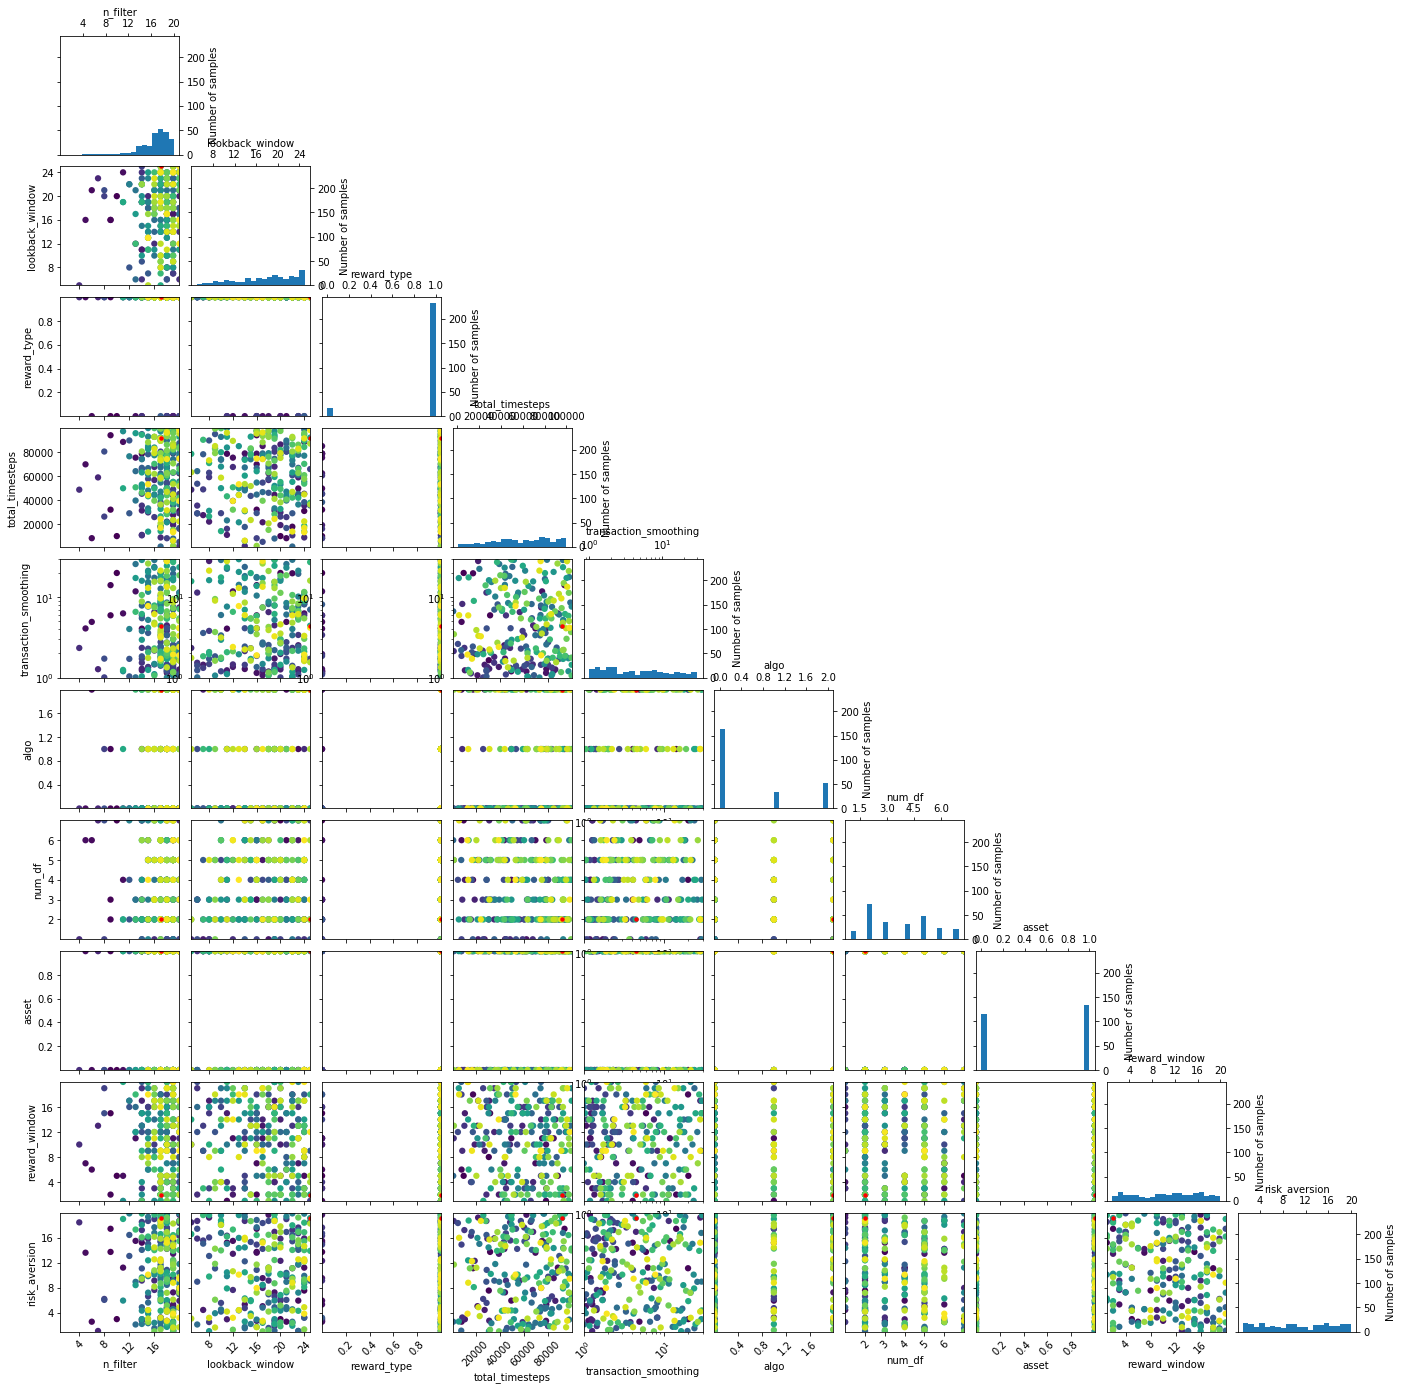

In [16]:
plots.plot_evaluations(results_we)

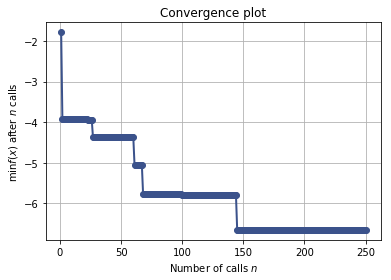

In [17]:
plots.plot_convergence(results_we)